# CO Column Density Math

November 20, 2023

See notes in CO_column_densities. Doing a bunch of math to learn about CO line ratios under different conditions and trying to figure out what I can use for M16.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from astropy.modeling import models, fitting

## Integrate ln(ratio of ratios)
There's this weird expression that I got for the ratio of $\tau$ optical depth. Following from the equation given by Okada et al. 2015 for $\tau$
$$ \tau_\nu = -{\rm ln} \Big[ 1 - \frac{kT_B(\nu)}{\eta h \nu} \Big\{ {\rm exp}\Big( \frac{h\nu}{kT_{ex}} \Big) - 1 \Big\} \Big] $$
you can rework it into
$$\int \frac{{\rm ln} (1 -\frac{T_{B,x}(\nu_x)}{\eta J_x(T_{ex})})}{{\rm ln} ( 1- \frac{T_{B,y}(\nu_y)}{\eta J_y(T_{ex})})} dv$$

Let's assume CO 3-2 and 1-0 and Gaussian line profiles with the same width. I'll leave the line brightnesses as variables. General Gaussian formula
$$ g(x) = \frac{1}{\sqrt{2\pi \sigma^2}} {\rm exp}\Big(\frac{-(x - \mu)^2}{2\sigma^2}\Big) $$
and simplification for $T_B$ (can figure out the coefficients later)
$$ T_B(v) = b\ {\rm exp}(-c v^2) $$

Furthermore, let's let
$${\rm ln} (1 -\frac{T_{B,x}(\nu_x)}{\eta J_x(T_{ex})}) = {\rm ln} (1 - a T_B(v)) $$
and also define $d \equiv ab$ so that the full thing looks like
$${\rm ln} (1 - d\ {\rm exp}(-c v^2)) $$

In [2]:
def log_function_single_line(v, c=1, d=1):
    return -np.log(1 - d*np.exp(-c * v**2))

/tmp/ipykernel_113892/1646972933.py:2: RuntimeWarning: divide by zero encountered in log
  return -np.log(1 - d*np.exp(-c * v**2))


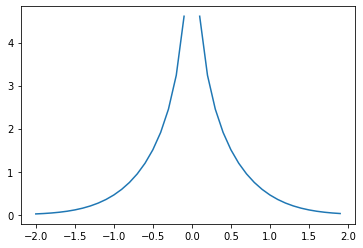

In [3]:
x_arr = np.arange(-2, 2, 0.1)
y_arr = log_function_single_line(x_arr)
plt.plot(x_arr, y_arr)

Interesting, goes to infinity at the line center. I guess that means optical depth is high at the line center and 0 far away, so that makes sense.

Let me try to just code up this equation
$$ \tau_\nu = -{\rm ln} \Big[ 1 - \frac{kT_B(\nu)}{\eta h \nu} \Big\{ {\rm exp}\Big( \frac{h\nu}{kT_{ex}} \Big) - 1 \Big\} \Big] $$

In [4]:
def calc_tau(tb, freq, tex, eta=1):
    """
    The Okada 2015 tau equation
    :param tb: T_B, K. Line brightness at velocity v
    :param freq: line rest frequency, Hz or equivalent
    :param tex: T_ex, K. Line excitation temperature.
    :param eta: filling factor, unitless
    """
    ktb_hnu = const.k_B * tb / (eta * const.h * freq)
    exp_hnu_kt = np.exp(const.h*freq / (const.k_B * tex)) - 1
    return -np.log(1 - ktb_hnu*exp_hnu_kt)

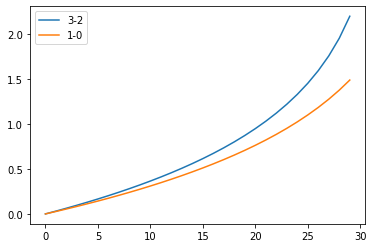

In [5]:
tb_arr = np.arange(0, 30) * u.K
tex = 40 * u.K
tau_arr_32 = calc_tau(tb_arr, 330*u.GHz, tex)
tau_arr_10 = calc_tau(tb_arr, 110*u.GHz, tex)
plt.plot(tb_arr, tau_arr_32, label="3-2")
plt.plot(tb_arr, tau_arr_10, label="1-0")
plt.legend()

In [6]:
def line_temp(velocity, height, width=None):
    """
    :param height: peak line temperature in K
    :param width: line FWHM in km/s. if not set, defaults to 1 km/s
    :returns: line temperature at given velocity
    """
    if width is None:
        width = 1*u.km/u.s
    g = models.Gaussian1D(amplitude=height, stddev=width/2.355, mean=0*u.km/u.s)
    return g(velocity)

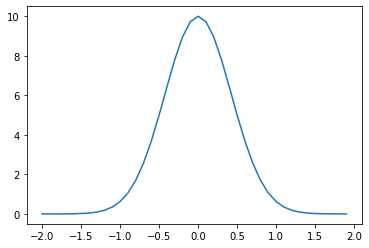

In [7]:
v_arr = np.arange(-2, 2, 0.1)*u.km/u.s
t_arr = line_temp(v_arr, 10*u.K)
plt.plot(v_arr, t_arr)

Looks like a line!

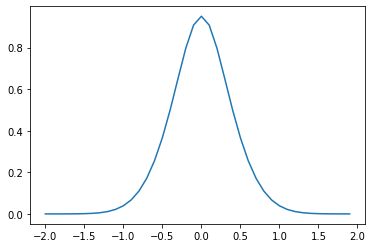

In [8]:
v_arr = np.arange(-2, 2, 0.1)*u.km/u.s
tex = 40 * u.K
tau_arr_32 = calc_tau(line_temp(v_arr, 20*u.K), 330*u.GHz, tex)
plt.plot(v_arr, tau_arr_32)

Looks like a reasonable optical depth! It matches by-eye the optical depth plot by line brightness for a fixed Tex.

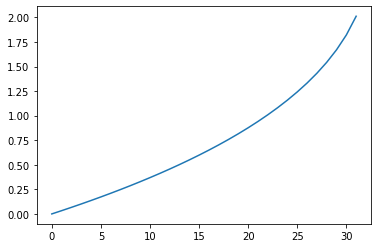

In [9]:
tb_arr = np.arange(0, 32) * u.K
v_arr = np.arange(-2, 2, 0.1) * u.km/u.s
tex = 40 * u.K
g = models.Gaussian1D(amplitude=tb_arr[:, np.newaxis], stddev=1*u.km/u.s/2.355, mean=0*u.km/u.s)
tau_grid = calc_tau(g(v_arr[np.newaxis, :]), 330*u.GHz, tex)
integrated_tau_arr = np.trapz(tau_grid, x=v_arr, axis=1)
plt.plot(tb_arr, integrated_tau_arr)

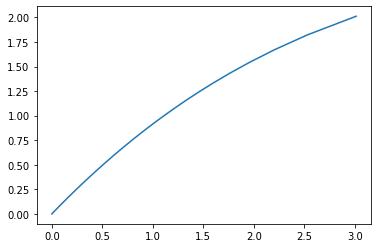

In [10]:
tau_peak = calc_tau(g(0*u.km/u.s), 330*u.GHz, tex)[:, 0]
plt.plot(tau_peak, integrated_tau_arr)

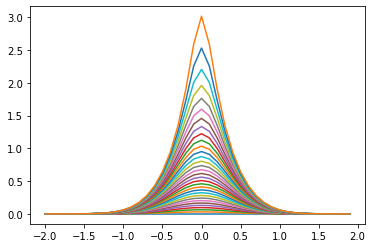

In [11]:
for i in range(tau_grid.shape[0]):
    plt.plot(v_arr, tau_grid[i, :])

Okay, ratio of ratios now. We know the ratios are like 2-4, so I'll try ratios of 1-5. These are 3-2/1-0. So I'll use the 1-0 as the "base".

In [12]:
tb_arr = np.arange(0, 32) * u.K
v_arr = np.arange(-2, 2, 0.1) * u.km/u.s
tex = 40 * u.K

def calc_integrated_tau(tb, freq):
    g = models.Gaussian1D(amplitude=tb[:, np.newaxis], stddev=1*u.km/u.s/2.355, mean=0*u.km/u.s)
    tau_grid = calc_tau(g(v_arr[np.newaxis, :]), freq, tex)
    integrated_tau_arr = np.trapz(tau_grid, x=v_arr, axis=1)
    return integrated_tau_arr

/home/ramsey/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in log
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/ramsey/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


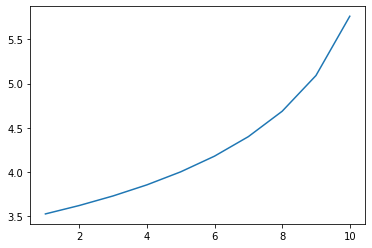

In [13]:
integrated_tau_arr_10 = calc_integrated_tau(tb_arr, 110*u.GHz)
integrated_tau_arr_32 = calc_integrated_tau(tb_arr*3, 330*u.GHz)
plt.plot(tb_arr, integrated_tau_arr_32/integrated_tau_arr_10)

This doesn't make much sense, I think I'm going in circles. Going back to the notes to rethink.

## What is a line profile

Ok I think I have a handle on what I'm supposed to do.
Fix both lines' $T_{ex}$ to the same value (high density limit). Pick one line and vary its optical depth, thin to thick. Then calculate the $T_B$ using that $T_{ex}$. Then I need to get the other $\tau$ from the column density equation. That's the hard part.

Is the line a Gaussian in optical depth? Or T_B? Or both? Or neither?

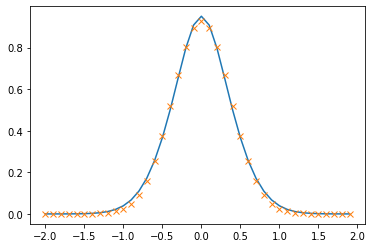

In [14]:
v_arr = np.arange(-2, 2, 0.1)*u.km/u.s
tex = 40 * u.K
tau_arr_32 = calc_tau(line_temp(v_arr, 20*u.K), 330*u.GHz, tex)
plt.plot(v_arr, tau_arr_32)
fitter = fitting.LevMarLSQFitter()
g0 = models.Gaussian1D()
g0.mean.fixed = True
g_fit = fitter(g0, v_arr.to_value(), tau_arr_32)
plt.plot(v_arr, g_fit(v_arr.to_value()), 'x')

In [15]:
def tb_from_tau(t, freq, tex):
    """
    Calculate T_B from tau
    :param t: tau optical depth, unitless
    :param freq: line rest freq, Hz equivalent
    :param tex: excitation temperature, K
    :returns: tb, K
    """
    a = (1 - np.exp(-t))
    b = (np.exp(const.h * freq / (const.k_B * tex)) - 1)
    coeff = const.h * freq / const.k_B
    return (coeff * a/b).to(u.K)

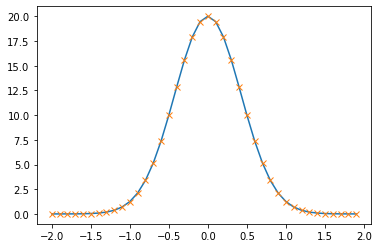

In [16]:
tb_arr_again = tb_from_tau(tau_arr_32, 330*u.GHz, tex)
plt.plot(v_arr, tb_arr_again)
plt.plot(v_arr, line_temp(v_arr, 20*u.K), 'x')

Let's try a Gaussian in optical depth, I assume this is where we can get a non-Gaussian T_B

1.6727532643018876
32.59842037888093 K 39.995923695934174 K


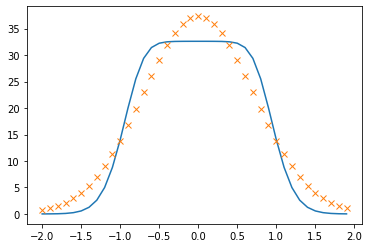

In [17]:
tex = 40*u.K
tau_arr = line_temp(v_arr, 9) # this function works fine for dimensionless tau
# plt.plot(v_arr, tau_arr)
tb_arr_again = tb_from_tau(tau_arr, 330*u.GHz, tex)
plt.plot(v_arr, tb_arr_again)
fitter = fitting.LevMarLSQFitter()
g0 = models.Gaussian1D()
g0.mean.fixed = True
g_fit = fitter(g0, v_arr.to_value(), tb_arr_again)
plt.plot(v_arr, g_fit(v_arr.to_value()), 'x')
print(g_fit.stddev * 2.355)

# Convert max T_B to T_ex assuming thick (undo RJ)
# Use the Okada equation solved for Tex
tex_meas = ((const.h * 330*u.GHz / const.k_B) / np.log((const.h * 330*u.GHz / (const.k_B * tb_arr_again.max())) + 1)).to(u.K)
print(tb_arr_again.max(), tex_meas)

This makes sense! optically thin line is Gaussian in both $\tau$ and $T_B$. Optically thick shows the pattern I'd expect for optically thick line: flat top.

This means that I should make the Gaussians in $\tau$, not $T_B$. That will make integration a lot easier.

# Varying tau

~~I figured out the right equation to use:~~
$$ 3 \times {\rm exp}\Big( -15.86~{\rm K} / T_{ex} \Big) = \frac{\tau_{3-2}}{\tau_{1-0}} $$
Nope not that one!

Try this one, where I don't drop $-1$ terms.
$$3 \times {\rm exp}(-26.44/T_{ex}) \frac{{\rm exp}(15.87/T_{ex}) - 1}{{\rm exp}(5.29/T_{ex}) - 1} = \frac{\tau_{3-2}}{\tau_{1-0}}$$

I fix $T_{ex}$ and vary one optical depth as the independent variable. The other optical depth is the dependent variable calcualted by this equation. I have to calculate peak $T_B$ using each optical depth in turn.

I will choose to set CO 1-0 by hand and calculate 3-2.

In [18]:
def tau_32_from_10(tau10, tex):
    """
    Don't forget -1s!
    :param tau10: optical depth of 1-0 line
    :param tex: Excitation temperature, K
    """
    # 3 exponential terms; make quick function for them
    exp_func = lambda x : np.exp(x/tex)
    # this is on its own, and negative (it was denominator)
    e1 = exp_func(-26.44*u.K)
    # these two have -1s
    e2 = exp_func(15.87*u.K) - 1
    e3 = exp_func(5.29*u.K) - 1
    return tau10 * 3 * e1 * e2 / e3

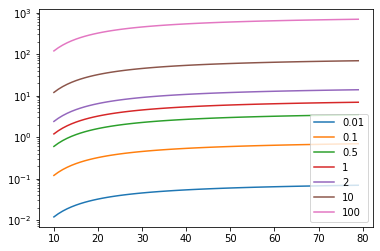

In [19]:
tex_arr = np.arange(10, 80) * u.K
for t in [0.01, 0.1, 0.5, 1, 2, 10, 100]:
    tau32_varying_tex = tau_32_from_10(t, tex_arr)
    plt.plot(tex_arr, tau32_varying_tex, label=f"{t}")
plt.legend()
plt.yscale('log')

In [20]:
def tb_ratio(tau10, tex):
    """
    Get the 32/10 line peak brightness ratio based on the 1-0 optical depth
    :param tau10: optical depth of 1-0 line
    :param tex: Excitation temperature, K
    """
    tau32 = tau_32_from_10(tau10, tex)
    tb32 = tb_from_tau(tau32, 330*u.GHz, tex)
    tb10 = tb_from_tau(tau10, 110*u.GHz, tex)
    return tb32/tb10

In [32]:
tex = 30*u.K
tau10_arr = [0.00001, 0.001, 0.1, 1, 10]
for t10 in tau10_arr:
    t32 = tau_32_from_10(t10, tex)
    print(f"t10, t32: {t10:.1E}, {t32:.1E}")
    tb32 = tb_from_tau(t32, 330*u.GHz, tex)
    tb10 = tb_from_tau(t10, 110*u.GHz, tex)
    print(f"T_B 10, T_B 32, ratio: {tb10:.1f}, {tb32:.1f}, {tb32/tb10:.2f}")

t10, t32: 1.0E-05, 4.5E-05
T_B 10, T_B 32, ratio: 0.0 K, 0.0 K, 3.73
t10, t32: 1.0E-03, 4.5E-03
T_B 10, T_B 32, ratio: 0.0 K, 0.1 K, 3.72
t10, t32: 1.0E-01, 4.5E-01
T_B 10, T_B 32, ratio: 2.6 K, 8.2 K, 3.16
t10, t32: 1.0E+00, 4.5E+00
T_B 10, T_B 32, ratio: 17.3 K, 22.5 K, 1.30
t10, t32: 1.0E+01, 4.5E+01
T_B 10, T_B 32, ratio: 27.4 K, 22.8 K, 0.83


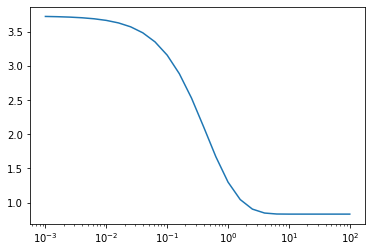

In [33]:
tex = 30*u.K
tau10_arr = 10**np.arange(-3, 2.1, 0.2)
tb_ratio_arr = tb_ratio(tau10_arr, tex)
plt.plot(tau10_arr, tb_ratio_arr)
plt.xscale('log')

This is confusing! I may have gotten some numbers/constants wrong.
The optically thick limit I had prevoiusly said
$$  \frac{J_{3-2}(T_{ex})}{J_{1-0}(T_{ex})} = \frac{3}{{\rm exp}\big(10\ {\rm K}/T_{ex}\big)}  $$
***But this was wrong! I dropped a -1 in the derivation***

This is the correct equation:
$$ \frac{J_{3-2}(T_{ex})}{J_{1-0}(T_{ex})} = \frac{\nu_{3-2}}{\nu_{1-0}} \Big(\frac{{\rm exp}(h\nu_{3-2}/kT_{ex}) -1}{{\rm exp}(h\nu_{1-0}/kT_{ex}) -1}\Big)^{-1} $$

In [23]:
ehnuktm1 = lambda nu, tex : np.exp(const.h * nu / (const.k_B * tex)) - 1
jpartial = lambda nu, tex : nu / ehnuktm1(nu, tex)
tex = 30*u.K
thick_ratio = jpartial(330*u.GHz, tex) / jpartial(110*u.GHz, tex)
print(thick_ratio)

0.8300512730423592


It works!! I just derived it wrong the first time!

Now I will debug the optically thin approximation, where we got ~4 instead of ~1.4 like here.

In [24]:
print(9/np.exp(26.44/30))

3.7280721269830543


It works!!! **I dropped -1 terms in the marginal derivation as well, I fixed those now**

Proof that everything works below.

## Thick and thin cases

In [107]:
ehnuktm1 = lambda nu, tex : np.exp(const.h * nu / (const.k_B * tex)) - 1
jpartial = lambda nu, tex : nu / ehnuktm1(nu, tex)

tex = 100*u.K

thick_ratio = jpartial(330*u.GHz, tex) / jpartial(110*u.GHz, tex)
print(f"Thick analytical limit {thick_ratio:.2f}")

t10 = 10
t32 = tau_32_from_10(t10, tex)
tb32 = tb_from_tau(t32, 330*u.GHz, tex)
tb10 = tb_from_tau(t10, 110*u.GHz, tex)
print(f"Full calc, thick limit {tb32/tb10:.2f}")

print()

thin_ratio = 9/np.exp(26.44*u.K/tex)
print(f"Thin analytical limit {thin_ratio:.2f}")

t10 = 0.0001
t32 = tau_32_from_10(t10, tex)
tb32 = tb_from_tau(t32, 330*u.GHz, tex)
tb10 = tb_from_tau(t10, 110*u.GHz, tex)
print(f"Full calc, thick limit {tb32/tb10:.2f}")

Thick analytical limit 0.95
Full calc, thick limit 0.95

Thin analytical limit 6.91
Full calc, thick limit 6.91


# Comparing with Radex
Via spectralradex.

The point here is to verify that all these equations reflect what is "really" going on when you do non-LTE stuff. I'll set density to a high number 1e9, and use range of column densities that sample optically thin, marginal, and thick.

In [58]:
from spectralradex import radex

In [63]:
params = radex.get_default_parameters()
l = max([len(p) for p in params])
params['fmin'] = 100
params['fmax'] = 400
params['h2'] = 1e9
for k in params:
    print(f"{k:>{l+1}}", "-"*4, params[k])

   molfile ---- co.dat
      tkin ---- 30.0
       tbg ---- 2.73
     cdmol ---- 10000000000000.0
        h2 ---- 1000000000.0
         h ---- 0.0
        e- ---- 0.0
      p-h2 ---- 0.0
      o-h2 ---- 0.0
        h+ ---- 0.0
 linewidth ---- 1.0
      fmin ---- 100
      fmax ---- 400
  geometry ---- 1


In [71]:
result = radex.run(params)
selected_rows = result.loc[result['Qup'].apply(int).isin([1, 3])]
selected_rows

,E_UP (K),freq,WAVEL (um),T_ex,tau,T_R (K),POP UP,POP LOW,FLUX (K*km/s),FLUX (erg/cm2/s),Qup,Qlow
0,5.53,115.271202,2600.757633,30.000160,0.000214,0.005663,0.223033,0.089399,0.006029,1.189194e-10,1,0
2,33.19,345.795990,866.963374,29.999666,0.000930,0.020845,0.206978,0.257068,0.022190,1.181640e-08,3,2


In [75]:
tr_col = selected_rows['T_R (K)']
tr_col

0    0.005663
2    0.020845
Name: T_R (K), dtype: float64

In [77]:
tr_col.iloc[1], tr_col.iloc[0]

(0.020845351972412742, 0.005663477265736648)

In [80]:
print(f"3-2/1-0 ratio at N(CO) {params['cdmol']:.1E}, tau10 {selected_rows['tau'].iloc[0]:.2E} : {tr_col.iloc[1]/tr_col.iloc[0]:.2f}")

3-2/1-0 ratio at N(CO) 1.0E+13, tau10 2.14E-04 : 3.68


Now all together, and can easily vary column density.

In [103]:
def radex_ratio_32_10(n_co, tk):
    """
    Print ratio of 3-2 / 1-0 line brightness given column density of CO and kinetic temperature.
    :param n_co: float coldens of CO in cm-2. Default is 1e13 which gives CO 1-0 optical depth ~ 1e-4. 1e17 is like 1e21ish N(H2)
    :param tk: float kinetic temperature in K. Default is 30.
    :returns: None, just prints.
    """
    params = radex.get_default_parameters()
    l = max([len(p) for p in params])
    params['fmin'] = 100
    params['fmax'] = 400
    params['h2'] = 1e9
    params['cdmol'] = n_co
    params['tkin'] = tk
    result = radex.run(params)
    selected_rows = result.loc[result['Qup'].apply(int).isin([1, 3])]
    tr_col = selected_rows['T_R (K)']
    print(f"tau10 {selected_rows['tau'].iloc[0]:.2E} ------ (3-2/1-0) {tr_col.iloc[1]/tr_col.iloc[0]:.2f}")

In [109]:
tk = 100
for power10 in [11, 13, 15, 17, 19, 21]:
    radex_ratio_32_10(10**power10, tk)

tau10 2.10E-07 ------ (3-2/1-0) 6.87
tau10 2.10E-05 ------ (3-2/1-0) 6.87
tau10 2.10E-03 ------ (3-2/1-0) 6.83
tau10 2.10E-01 ------ (3-2/1-0) 3.93
tau10 2.10E+01 ------ (3-2/1-0) 0.95
tau10 2.10E+03 ------ (3-2/1-0) 0.95


These are essentially what I calculated directly! The differences on the order of 1/100 are probably from my round numbers for frequency and energy.